In [9]:
# Read in a single simulation:

In [ ]:
import numpy as np

def read_simulation_data(file_path):
    """
    Reads simulation data from a given file and returns the lists as arrays.

    param file_path: Path to the file containing simulation data
    return data: A dictionary with names as keys and arrays as values
    """
    data = {}
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Parse the header to verify structure (optional but good for clarity)
    header_line = lines[3].strip()  # The fourth line contains the order
    variable_order = header_line.lstrip("# ").split(",")

    # Parse each variable's data
    for i, key in enumerate(variable_order):
        # The data for each variable starts after the header
        data[key] = np.array([float(value) for value in lines[i + 5].strip().split(",")])

    return data

# Set data file path here (manually)
file_path = "seasonal/data/simulation_data_36d4cd9a.csv" 
simulation_data = read_simulation_data(file_path)

# Accessing individual arrays
t_emerg = simulation_data["t_emerg"]
t = simulation_data["t"]
S = simulation_data["S"]
I1 = simulation_data["I1"]
I2 = simulation_data["I2"]
I12 = simulation_data["I12"]
I21 = simulation_data["I21"]
R1 = simulation_data["R1"]
R2 = simulation_data["R2"]
R = simulation_data["R"]

# Example output to check
print(f"Emergence times (t_emerg): {t_emerg}")
print(f"Time points (t): {t}")


In [ ]:
# Creating an emergence time density:
import numpy as np
import matplotlib.pyplot as plt
import glob

def combine_emergence_risks(simulation_outputs, T_max, bin_width=10):
    """
    Combines t_emerg values from multiple simulations and creates an emergence risk time-series.
    
    simulation_outputs: List of simulation data dictionaries, each containing "t_emerg".
    T_max: Maximum simulation time.
    bin_width: Width of time intervals for binning.
    returns: time_bins, emergence_density
    """
    # Combine all t_emerg values from all simulations
    all_t_emerg = []
    for sim_data in simulation_outputs:
        all_t_emerg.extend(sim_data["t_emerg"])  # Combine all emergence times
    
    # Create time bins
    time_bins = np.arange(0, T_max + bin_width, bin_width)
    
    # Histogram emergence events into bins
    emergence_counts, _ = np.histogram(all_t_emerg, bins=time_bins)
    
    # Convert counts to density
    # Divide by (bin_width * number of simulations) to normalize
    num_simulations = len(simulation_outputs)
    emergence_density = emergence_counts / (bin_width * num_simulations)
    
    # Return the time bins (aligned to bin centers) and emergence density
    time_bin_centers = time_bins[:-1] + bin_width / 2
    return time_bin_centers, emergence_density

data_dir = "seasonal/data/"
simulation_files = glob.glob(f"{data_dir}/simulation_data_*.csv")

# Read all simulation data
simulation_outputs = [read_simulation_data(file) for file in simulation_files]

# Combine emergence risks
T_max = 4000  # Maximum simulation time
time_bin_centers, emergence_density = combine_emergence_risks(simulation_outputs, T_max, bin_width=5)

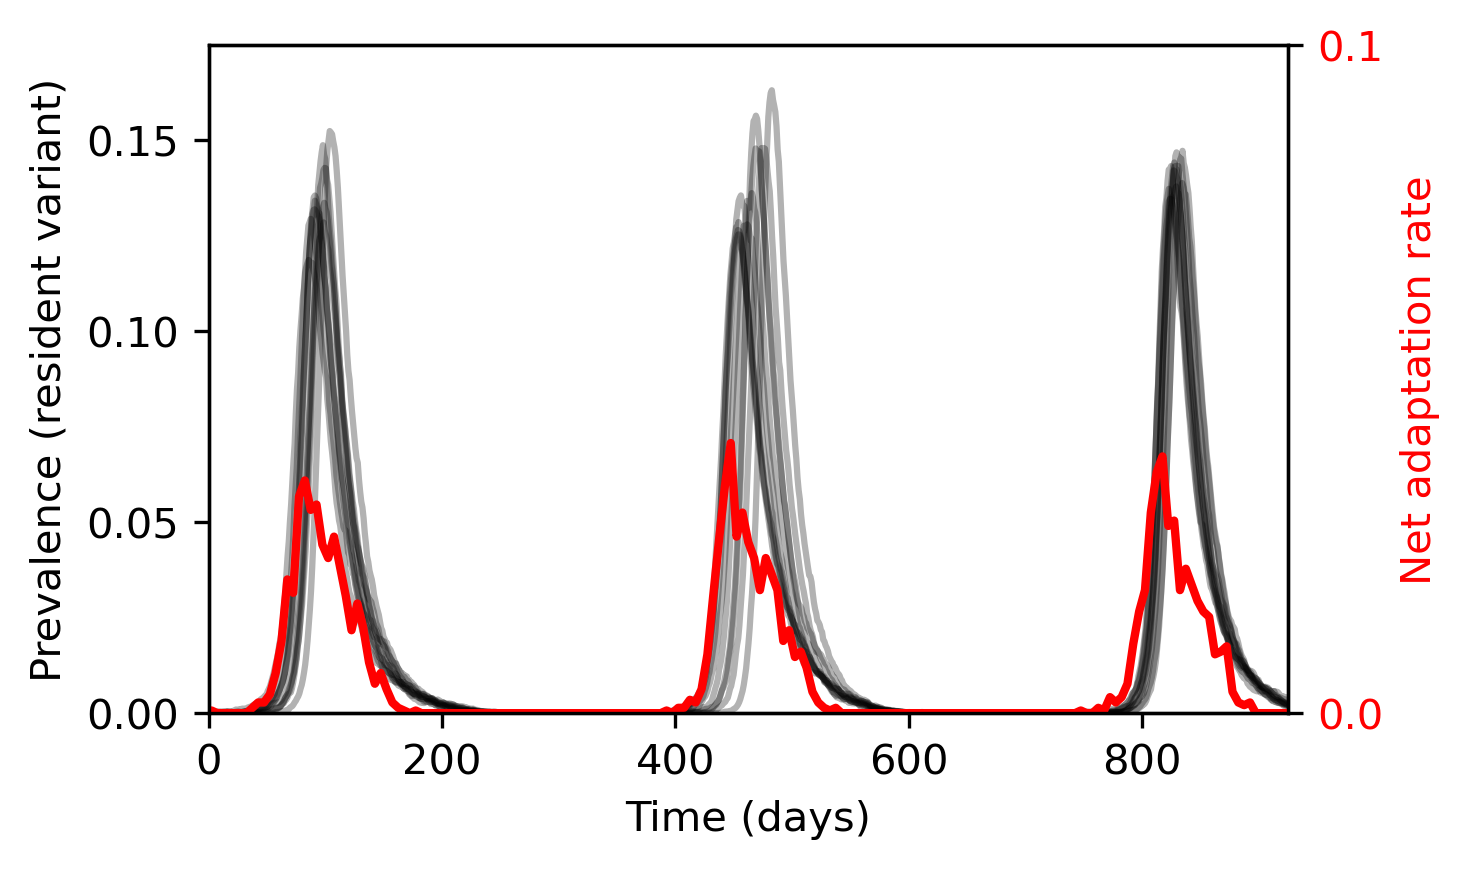

In [145]:
import random

def plot_emergence_and_prevalence(time_bin_centers, emergence_density, simulation_outputs, num_curves=10, alpha=0.3, t_min=500, t_max=2000):
    N = 40000
    # Set up the figure
    scale_factor = 0.75
    #fig, ax1 = plt.subplots(figsize=(7, 3), dpi=300)
    fig, ax1 = plt.subplots(figsize=(5, 3), dpi=300)

    # Select a random subset of simulations for prevalence curves
    selected_simulations = random.sample(simulation_outputs, min(num_curves, len(simulation_outputs)))

    # Plot prevalence curves (secondary y-axis)
    ax2 = ax1.twinx()
    for sim_data in selected_simulations:
        t = np.array(sim_data["t"])
        I1 = np.array(sim_data["I1"])
        I12 = np.array(sim_data["I12"])
        prevalence = I1 + I12
        ax1.plot(t-t_min, prevalence/N, color="black", alpha=alpha, linewidth=1.5, zorder=1)

    ax1.set_ylabel("Prevalence (resident variant)", color="black")
    ax1.set_yticks([0, 0.05, 0.10, 0.15])
    ax1.tick_params(axis="y", labelcolor="black")
    ax1.set_ylim([0, 7000/N])

    # Plot the emergence density 
    ax2.plot(time_bin_centers-t_min, emergence_density, label="Net adaptation rate", color="red", linewidth=2, zorder=2)
    ax1.set_xlabel("Time (days)")
    ax2.set_ylabel("Net adaptation rate", color="red")
    ax2.set_yticks([0, 0.1])
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.grid(False)

    # Set x-axis limits to restrict time range
    ax2.set_xlim(0, t_max-t_min)
    ax2.set_ylim([0, 0.1])

    #plt.title(f"Emergence Risk and Prevalence of Original Variant ({t_min} < t < {t_max})")
    fig.tight_layout()

    plt.show()

#plot_emergence_and_prevalence(time_bin_centers, emergence_density, simulation_outputs, num_curves=10, alpha=0.3, t_min=500, t_max=2000)
plot_emergence_and_prevalence(time_bin_centers, emergence_density, simulation_outputs, num_curves=10, alpha=0.3, t_min=2075, t_max=3000)
#plot_emergence_and_prevalence(time_bin_centers, emergence_density, simulation_outputs, num_curves=10, alpha=0.3, t_min=2000, t_max=3500)

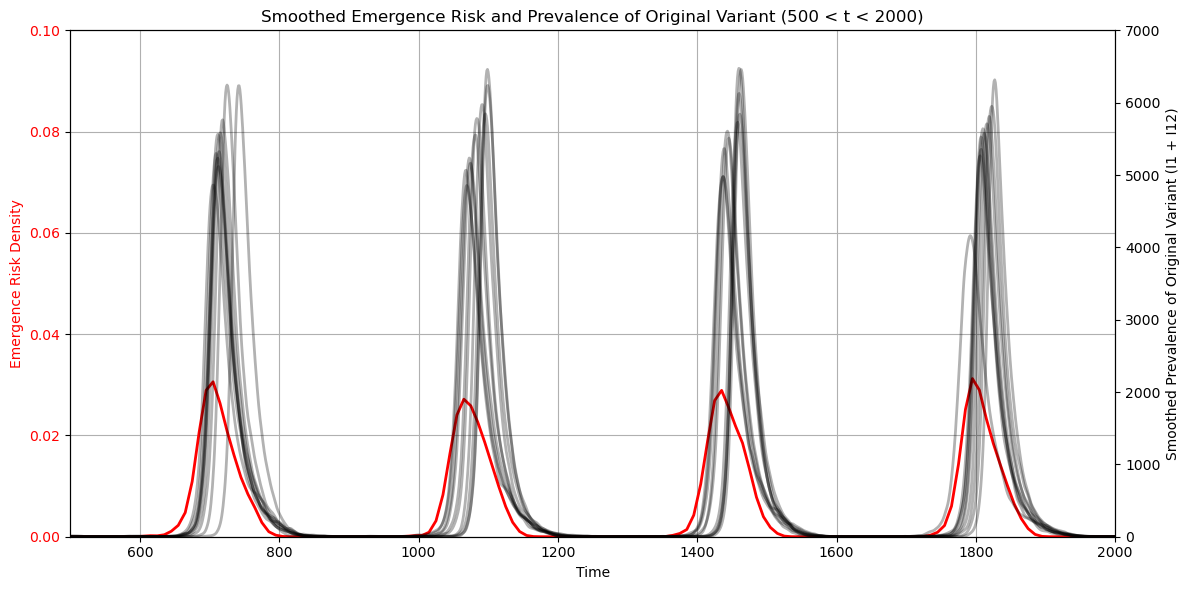

In [89]:
# Smoothed:

from scipy.ndimage import gaussian_filter1d
import random

def plot_smoothed_emergence_and_prevalence(time_bin_centers, emergence_density, simulation_outputs, num_curves=10, alpha=0.3, t_min=500, t_max=2000, sigma_risk=1, sigma_prevalence=2):
    # Smooth the emergence risk density
    smoothed_emergence_density = gaussian_filter1d(emergence_density, sigma=sigma_risk)

    # Set up the figure
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the smoothed emergence density (primary y-axis)
    ax1.plot(time_bin_centers, smoothed_emergence_density, label="Smoothed Emergence Risk Density", color="red", linewidth=2)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Emergence Risk Density", color="red")
    ax1.tick_params(axis="y", labelcolor="red")
    ax1.grid(True)

    # Select a random subset of simulations for prevalence curves
    selected_simulations = random.sample(simulation_outputs, min(num_curves, len(simulation_outputs)))

    # Plot smoothed prevalence curves (secondary y-axis)
    ax2 = ax1.twinx()
    for sim_data in selected_simulations:
        t = np.array(sim_data["t"])
        I1 = np.array(sim_data["I1"])
        I12 = np.array(sim_data["I12"])
        prevalence = I1 + I12

        # Smooth prevalence curve
        smoothed_prevalence = gaussian_filter1d(prevalence, sigma=sigma_prevalence)
        ax2.plot(t, smoothed_prevalence, color="black", alpha=alpha, linewidth=2)

    ax2.set_ylabel("Smoothed Prevalence of Original Variant (I1 + I12)", color="black")
    ax2.tick_params(axis="y", labelcolor="black")
    ax2.set_ylim([0, 7000])

    # Set x-axis limits to restrict time range
    ax1.set_xlim(t_min, t_max)
    
    ax1.set_ylim([0, 0.1])
    
    plt.title(f"Smoothed Emergence Risk and Prevalence of Original Variant ({t_min} < t < {t_max})")
    fig.tight_layout()

    plt.show()

plot_smoothed_emergence_and_prevalence(time_bin_centers, emergence_density, simulation_outputs, num_curves=10, alpha=0.3, t_min=500, t_max=2000, sigma_risk=1, sigma_prevalence=2)
